In [2]:
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier


df = pd.read_pickle(r"C:\SKN25-2nd-1Team\preprocessing\data\kkbox_v3.pkl")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   msno             970960 non-null  object  
 1   is_churn         970960 non-null  int64   
 2   txn_cnt          970960 non-null  float64 
 3   total_paid       970960 non-null  float64 
 4   avg_paid         970960 non-null  float64 
 5   avg_plan_days    970960 non-null  float64 
 6   auto_renew_rate  970960 non-null  float64 
 7   cancel_rate      970960 non-null  float64 
 8   total_cancel     970960 non-null  float64 
 9   avg_duration     970960 non-null  float64 
 10  max_duration     970960 non-null  float64 
 11  total_secs_sum   970960 non-null  float64 
 12  total_secs_mean  970960 non-null  float64 
 13  num_unq_mean     970960 non-null  float64 
 14  num_100_sum      970960 non-null  float64 
 15  num_985_sum      970960 non-null  float64 
 16  num_75_sum       970

In [4]:
df.columns

Index(['msno', 'is_churn', 'txn_cnt', 'total_paid', 'avg_paid',
       'avg_plan_days', 'auto_renew_rate', 'cancel_rate', 'total_cancel',
       'avg_duration', 'max_duration', 'total_secs_sum', 'total_secs_mean',
       'num_unq_mean', 'num_100_sum', 'num_985_sum', 'num_75_sum',
       'num_50_sum', 'num_25_sum', 'city', 'gender', 'registered_via',
       'age_group', 'no_log_flag'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    classification_report
)
y = df["is_churn"]
X = df.drop(columns=["is_churn", "msno"])

# (핵심) 컬럼명 문자열화
X.columns = X.columns.map(str)

cat_cols = X.select_dtypes(include=["object", "category"]).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()

model = XGBClassifier(
    n_estimators=200,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss"
)

model.fit(X_tr, y_tr)

# =========================================================
# 7) 검증 (AP + confusion matrix + report)
# =========================================================
va_proba = model.predict_proba(X_va)[:, 1]
va_pred = (va_proba >= 0.5).astype(int)

ap = average_precision_score(y_va, va_proba)
cm = confusion_matrix(y_va, va_pred)

print("\nAP:", ap)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_va, va_pred))


AP: 0.9497439093096279

Confusion Matrix:
[[172675   4051]
 [   900  16566]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    176726
           1       0.80      0.95      0.87     17466

    accuracy                           0.97    194192
   macro avg       0.90      0.96      0.93    194192
weighted avg       0.98      0.97      0.98    194192



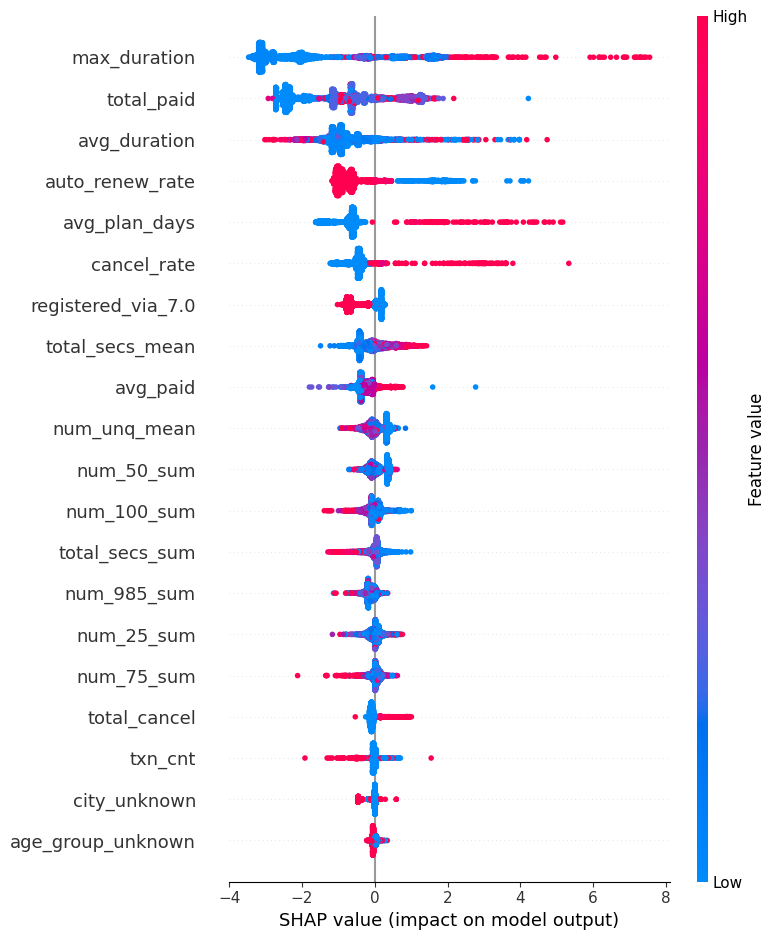

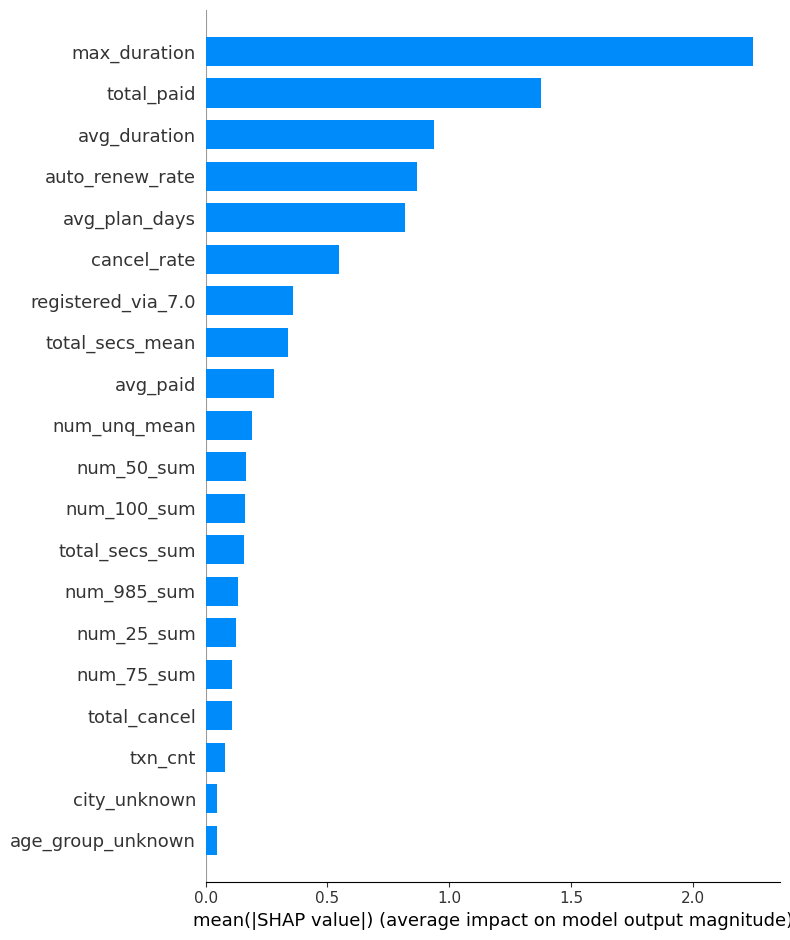

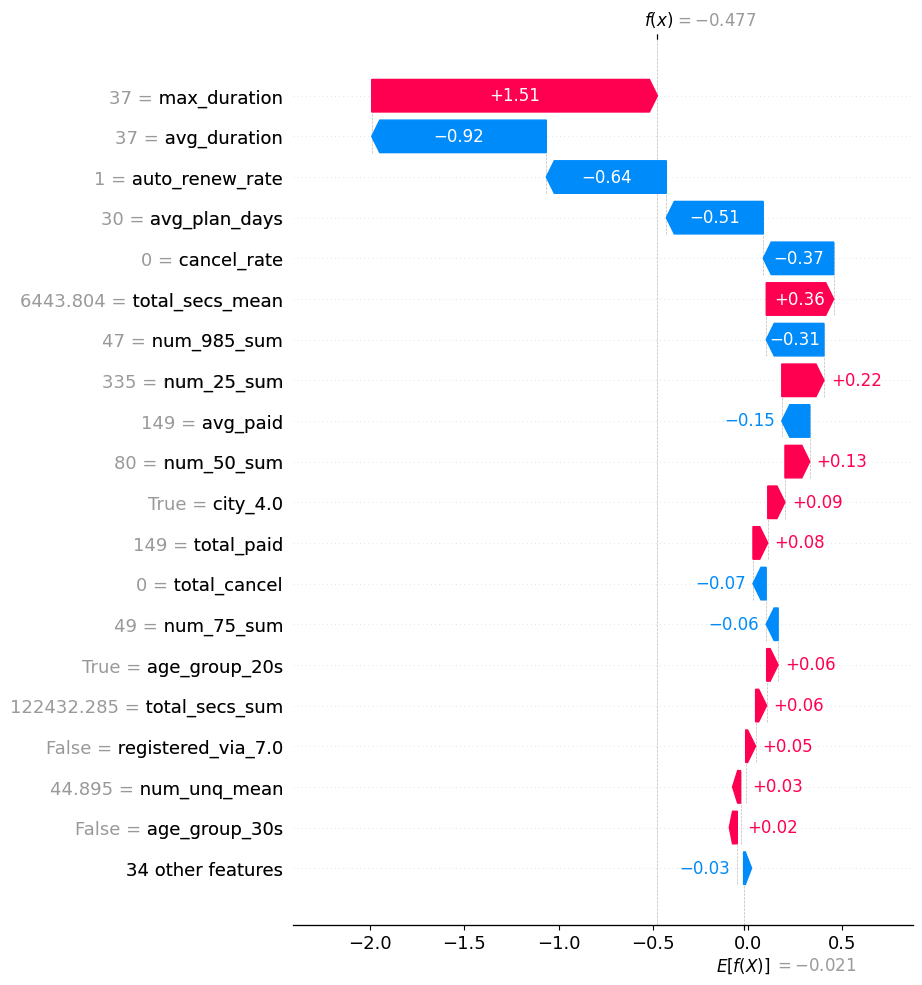

In [12]:
# =========================================================
# 8) SHAP (XGBoost)
# =========================================================
import shap
import numpy as np
import matplotlib.pyplot as plt

# (선택) 속도/메모리 줄이기: 샘플링
# 너무 크면 2~5천 정도로 줄이는 걸 추천
MAX_BG = 2000
MAX_EXPL = 3000

bg = X_tr.sample(min(len(X_tr), MAX_BG), random_state=42)
X_explain = X_va.sample(min(len(X_va), MAX_EXPL), random_state=42)

# TreeExplainer (XGBoost용)
explainer = shap.TreeExplainer(model)

# shap 값 계산
# - binary classification이면 보통 (n_samples, n_features) 형태로 나옴
shap_values = explainer.shap_values(X_explain)

# ---------------------------------------------------------
# 8-1) 전역 중요도: summary plot (beeswarm)
# ---------------------------------------------------------
shap.summary_plot(shap_values, X_explain, show=False)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 8-2) 전역 중요도: bar plot (mean(|SHAP|))
# ---------------------------------------------------------
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 8-3) 개별 샘플 설명: waterfall (한 명)
# ---------------------------------------------------------
i = 0  # 보고 싶은 인덱스 (0~)
row = X_explain.iloc[i]

# shap.Explanation 형태로 만들어주면 waterfall이 깔끔함
# base_value는 explainer.expected_value (스칼라)인 경우가 대부분
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):  # 혹시 클래스별로 나오면 양성 클래스 선택
    base_value = base_value[1]

exp = shap.Explanation(
    values=shap_values[i],
    base_values=base_value,
    data=row.values,
    feature_names=X_explain.columns
)

shap.plots.waterfall(exp, max_display=20)

# ---------------------------------------------------------
# 8-4) (선택) dependence plot: 특정 피처의 영향 곡선
# ---------------------------------------------------------
# shap.dependence_plot("some_feature_name", shap_values, X_explain)